In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

In [141]:
# Veriyi oku
df = pd.read_csv("time_series_60min_singleindex.csv")
data = df['GB_GBN_solar_generation_actual'].values.reshape(-1, 1)  # Güneş enerjisi verisini al

In [142]:
# NaN ve sonsuz değerleri sıfır ile değiştir
data = np.nan_to_num(data)

In [143]:
# Veriyi ölçeklendir (LSTM genelde 0-1 arasında normalize edilmiş veri ile daha iyi çalışır)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [144]:
# Veriyi eğitim ve test setlerine ayır
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [145]:
# Veriyi X, y formatına dönüştür
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [146]:
# Zaman adımını belirle
time_step = 60  # Örneğin, 60 saatlik geçmişe bakarak tahmin yapalım
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [147]:
# LSTM modelinin girişi 3 boyutlu olmalı (örnek sayısı, zaman adımı, özellik sayısı)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [148]:
# Veride NaN veya sonsuz değer var mı kontrol et
print("NaN değer sayısı:", np.isnan(scaled_data).sum())
print("Sonsuz değer sayısı:", np.isinf(scaled_data).sum())

NaN değer sayısı: 0
Sonsuz değer sayısı: 0


In [149]:
# NaN değerleri sıfır ile değiştir
scaled_data = np.nan_to_num(scaled_data)

In [150]:
# Modeli oluştur
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dense(1))

/home/tylefnx/.dev/._pyvenv32/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [151]:
# Modeli derle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [152]:
# Modeli eğit
model.fit(X_train, y_train, batch_size=64, epochs=20)


Epoch 1/20


630/630 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.0098
Epoch 2/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0013
Epoch 3/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 9.6390e-04
Epoch 4/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 9.6005e-04
Epoch 5/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 9.2827e-04
Epoch 6/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 9.5451e-04
Epoch 7/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 8.9878e-04
Epoch 8/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 8.7097e-04
Epoch 9/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 8.5926e-04
Epoch 10/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 8.3127e-04
Epoch 11/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 8.6675e-04
Epoch 12/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 8.1973e-04
Epoch 13/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 8.2180e-04
Epoch 14/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 7.9

In [153]:
# Test verileriyle tahmin yap
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Tahmin edilen veriyi geri ölçeklendir (inverse scaling)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# NaN değerlerini kontrol et
print(f"Train predictions: {train_predict[:5]}")  # İlk 5 tahmini yazdır
print(f"Test predictions: {test_predict[:5]}")    # İlk 5 tahmini yazdır


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Train predictions: [[197.36687]
 [242.87021]
 [274.73526]
 [233.86159]
 [166.9397 ]]
Test predictions: [[3034.6746]
 [3469.6863]
 [3950.8232]
 [3923.128 ]
 [3230.0305]]


In [154]:
# Tahmin edilen veriyi geri ölçeklendir (inverse scaling)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [155]:
# Tahminleri ters ölçeklendirme
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [156]:
print(train_predict)

[[ 197.36687]
 [ 242.87021]
 [ 274.73526]
 ...
 [ 192.20654]
 [ -90.74896]
 [-106.2743 ]]


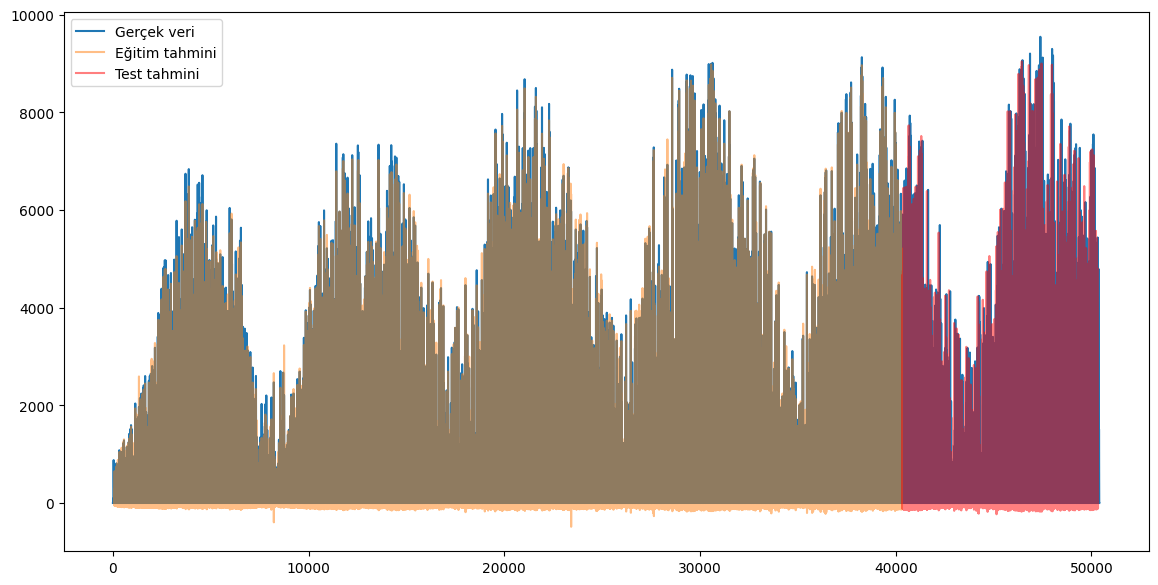

In [157]:
# Test aralığını doğru hesaplayalım
train_len = len(train_predict) + time_step
test_len = len(test_predict)

# Test verilerini çizeceğimiz x ekseni
test_range = np.arange(train_len, train_len + test_len)

# Grafiği çizelim
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(scaled_data), label="Gerçek veri")
plt.plot(np.arange(time_step, train_len), train_predict, label="Eğitim tahmini",alpha=0.5)
plt.plot(test_range, test_predict, label="Test tahmini",alpha=0.5,color= "red")
plt.legend()
plt.show()